# Unit Testing

This notebook uses visual representations to check the the dimentions of each input and output.

Then, we test different methods for unpacking the linear layer at the end of the recurrent mechanism.

In [1]:
import numpy as np
import pandas as pd
import sys, os
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import talib as ta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# MAKE SURE WE HAVE THE ENVIRONMENT CONFIGURED PROPERLY
%cd ../src/main
SCRIPT_DIR = os.path.dirname(os.path.abspath("."))
if 'backend' not in os.listdir('.'):
    sys.path.insert(0, os.path.abspath(SCRIPT_DIR))

from backend.stock_dataset import (
    StockDataset
)
from backend.technical_analysis import get_data_set

/home/jackb/columbia/TFJ-DRL-update1/src/main


Getting CUDA

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device(f'cuda:{torch.cuda.device_count()-1}')
else:
    DEVICE = torch.device('cpu')

ENV_SIZE = 128

DEVICE

device(type='cuda', index=0)

Getting the dataset

In [3]:
#Data Generation

stockList1=['COO','COF','ABBV','CCL','AMD','GOOG',
            'ABT','ACN','ADBE','AES','NVDA',
            'AIG','ALL', 'AMG','AMZN','APA','AAPL',
            'AXP','BA','BBY','CAT','GE', 'CSCO', 
            'EA','EQR','FCX','FE',
            'HST','IBM','INTC','JCI','MMM','MO',
            'ORCL','PPL','T','EXPD','VMC','VNO']
if 'stock_dataset.npy' in os.listdir('../data'):
    full_list = np.load(file='../data/stock_dataset.npy')
    print("Loaded previous generation")
else:
    print("Generating new dataset")
    full_list=get_data_set(stockList1, start="2017-01-01", end="2020-01-01", verbose=True, coint_threshold=0.1)
    np.save(file='../data/stock_dataset.npy', arr=full_list)

print(f"Loaded dataset of {full_list.shape[0]} tickers, {full_list.shape[1]} ticks, {full_list.shape[2]} features/tick.")

Loaded previous generation
Loaded dataset of 39 tickers, 664 ticks, 86 features/tick.


### Definining the recurrent attention (supervised) model

We will modify the feed-forward (`nn.Linear`) portion of the model to return the latent representation of the price at $t+1$

Before we have $W_1 \in \mathbb{R^{256 \times \text{env\_size}}}$, $W_2 \in \mathbb{R^{\text{env\_size} \times \text{1}}}$:

$$\hat{\text{price}}_{t+1} = RELU(W_1 \cdot (h_t \oplus \text{attention}(h_t)))W_2$$


To 'crack open' the model we will change its forward function to return the hidden vector $RELU(W_1 \cdot (h_t \oplus \text{attention}(h_t)))$. This is primarily what we will test on.

In [4]:
from backend.reinforcement_learning import tam

#define GRU class
#init parameter: env_size for RL algorithm
class GRU(nn.Module):
    def __init__(self, env_size):
        super(GRU, self).__init__()
        self.rnn=nn.GRU(
            input_size=86,
            hidden_size=128,
            num_layers=1,
            batch_first=True
        )
        self.linear1=nn.Linear(256, env_size)
        self.linear2=nn.Linear(env_size, 1)
        self.num_layers=1
        
    def forward(self, x, state, device):
        batch_size,timestep, _=x.shape
        states, state=self.rnn(x, state)
        tamVec=tam(states, device)
        
        #concatVec: batch_size, time_step, hidden_size*2
        #i.e.       batch_size, 24       , 256        
        concatVec=torch.cat([states, tamVec],axis=2)
        envVec=self.linear1(torch.tanh(concatVec.reshape(batch_size*timestep, -1)))
        output=nn.Dropout(p=0.3)(envVec)
        output=nn.ReLU()(output)
        # hidden_output=nn.ReLU()(output) # HERE
        output=self.linear2(output)
        envVec=envVec.reshape(batch_size, timestep, -1)
        return (output.view(batch_size, -1), envVec), state#, hidden_output
  
    def begin_state(self, device, batch_size=1): 
        # `nn.GRU` takes a tensor as hidden state
        return torch.zeros((
                    self.rnn.num_layers, batch_size, 128), device=device)

tam_gru = GRU(env_size=ENV_SIZE).to(DEVICE)
tam_gru

GRU(
  (rnn): GRU(86, 128, batch_first=True)
  (linear1): Linear(in_features=256, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
)

We need to redefine the `rlPolicy` agent as well. The `rlPolicy` agent is the one which recieves the loss at a given timestep $t$ during training, so it needs to pass that loss backwards to the `tam_gru` model as well.

Between the `tam_gru` model and policy agent we add a decoder model which reconstructs the `hidden_state` vector from the `hidden_output` vector.

To train the decoder, need a new loss function on top of the loss function from the paper. This new loss will be the angular difference between the `hidden_output` vector and the `predicted_hidden_output` vector. As we track this loss through time, it may clue us in to the `tam_gru` model's ability to represent the state. Higher loss means the `tam_gru` is treading uncharted territory, so to speak, which makes the policy agent ***confused***. This is how the decoder loss functions as a confusion metric for the model.

In [5]:
class AutoEncoder(nn.Module):
    """Auto-encoder to get a latent representation of the hidden state, 
    then decode to get the confusion"""
    def __init__(self, env_size, device: torch.device):
       super(AutoEncoder, self).__init__()
       
       self.encoder = nn.Sequential(
           nn.Linear(env_size, 32),
           nn.LeakyReLU(),
           nn.Dropout(p=0.3),
           nn.Linear(32, 16),
           nn.ReLU(),
           nn.Linear(16, 2)
       )
       
       self.decoder = nn.Sequential(
           nn.Linear(2, 16),
           nn.LeakyReLU(),
           nn.Dropout(p=0.3),
           nn.Linear(16, 32),
           nn.ReLU(),
           nn.Linear(32, env_size)
       )
    
    def forward(self, x):
        hidden = self.encoder(x)
        output = self.decoder(hidden)
        return hidden, output

decoder = AutoEncoder(ENV_SIZE, DEVICE).to(DEVICE)
decoder

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Linear(in_features=16, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=128, bias=True)
  )
)

In [6]:
from backend.reinforcement_learning import get_params, rlForwardFunc

class rlPolicy(nn.Module):
    """RL Policy net modeled by parameters"""
    def __init__(self, env_size, device: torch.device):
        super(rlPolicy, self).__init__()
        
        #self.linear = nn.Linear(32+1, 1)
        
        W, b, h=get_params(env_size, device)
        self.device=device
        self.W=nn.Parameter(W)
        self.b=nn.Parameter(b)
        self.h=nn.Parameter(h)
        # self.rnn=GRU(env_size) # using global model initialized above

    # Forward pass through the RL Policy network
    def forward(self, x):
        """
        Summary:
            RL forward function to compute actions
        Args:
            envs: States output by the GRU (shape: batch_size, num_steps, envs_size)
            params: Parameters initialized by get_params()

        Returns:
            Tensor of computed actions (shape: batch_size, num_steps, env_size)
        """
        W, b, h = self.W, self.b, self.h
        envs = x
        outputs = []
        tanh=nn.Tanh()
        # Shape of `X`: (`batch_size`, `envs_size`)
        for i in range(envs.shape[1]):
            X = envs[:,i,:]
            Y = torch.matmul(X, W) + b
            Z1 = tanh(Y)
            Z = Z1.clone()
            Z=Z.unsqueeze(1)
            
        
            if(i==0):
                outputs.append(Z)
            else:
                Z+=outputs[i-1]* h
                outputs.append(Z)
        return torch.cat(outputs, dim=1)
            
    # # Initialize the hidden state for the RL Policy network
    # def begin_state(self, device, batch_size=1):
    #     return self.rnn.begin_state(device, batch_size)

policy_agent = rlPolicy(ENV_SIZE, DEVICE)
policy_agent

rlPolicy()

In [7]:
#Calculate Utility based on policy Output
#z: z from dataset
#c: transaction cost
def _calcUtility(policyOutput, z, c=0.001):
  with torch.no_grad():
    discretize=policyOutput.detach()
    batch, step, _ = policyOutput.shape
    #discretize: batch, step, 3
    discretize=discretize.reshape(batch*step,-1)
    discretize=torch.argmax(discretize, dim=1, keepdim=True) #{0, 1, 2}
    discretize=discretize.reshape(batch, step)
    preAction=torch.cat([discretize[:,0:1], discretize[:, :-1]], dim=1)
    #net income R
    R=z*(discretize-1)-c*((discretize-preAction)!=0)
    U=torch.cumsum(R, dim=1)
    return U, preAction

#Calculate Utility based on policy Output
#z: z from dataset
#c: transaction cost
def calcUtility(policyOutput, z, c=0.0001):
  #with torch.no_grad():
    discretize=policyOutput.detach()
    discretize=(discretize>=0)*2-1
    preAction=torch.cat([discretize[:,0:1], discretize[:, :-1]], dim=1)
    #net income R
    R=z*discretize-c*((discretize-preAction)!=0)
    U=[]
    for i in range(R.shape[1]):
        if(i==0):
            u=R[:,i:i+1]
        else:
            u=R[:,i:i+1]+U[i-1]
        U.append(u)
    U=torch.cat(U, dim=1)
    return U, preAction

In [8]:
#Prevent exploding gradient
def grad_clipping(net, theta): 
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [9]:
#model weight initialization
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.normal_(0.0,0.01)

In [10]:
#Loss function defined by paper
def _lossFunc(predP, y, policyOutput, z, device):
    #MSE
    term1=nn.MSELoss()(predP, y)
    #RL
    U, preAction=calcUtility(policyOutput, z)
    U_detach=U.detach()
    sfPolicyOutput=nn.Softmax(dim=2)(policyOutput)
    actionProb=torch.squeeze(torch.gather(sfPolicyOutput, 2, torch.unsqueeze(preAction, -1)))
    term2=-torch.log(actionProb)*U_detach
    return term2.mean()+term1

#Loss function defined by paper
def lossFunc(predP, y, policyOutput, z, device: torch.device):
    #MSE
    term1=nn.MSELoss()(predP, y)
    #RL
    U, preAction=calcUtility(policyOutput, z)
    U_detach=U.detach()
    actionProb=(torch.tensor(1).to(device)+policyOutput)/torch.tensor(2)
    plusMinus=(preAction<0)*1
    term2=-torch.log(1*plusMinus+((-1)**plusMinus)*actionProb)*U_detach
    return term2.mean()+term1

In [11]:
#greedy loss function
def lossFunc2(predP, y, policyOutput, z, device):
    #MSE
    term1=nn.MSELoss()(predP, y)
    #RL
    greedyAction=(z>=0.01)*2
    one_hot=torch.nn.functional.one_hot(greedyAction)
    U, preAction=calcUtility(policyOutput, z)
    U_detach=U.detach()
    sfPolicyOutput=nn.Softmax(dim=2)(policyOutput)
    actionProb=torch.squeeze(torch.gather(sfPolicyOutput, 2, torch.unsqueeze(preAction, -1)))
    term2=-torch.log(actionProb)*U_detach
    term3=nn.CrossEntropyLoss()(policyOutput.view(-1, 3), greedyAction.view(-1))
    return 0.5*term3+term2.mean()+term1

# Define the new training function

Implicitly, we have 3 global models working together.

* `tam_gru`
* `decoder`
* `policy_agent`

In [12]:
#trainer for epoch
def train_epoch(train_iter, device, optim1, optim3, lossfn):
    loss_data=[]
    embed_list = []
    confusion_list = []
    with torch.autograd.set_detect_anomaly(True):
        for X, y, z, _ in train_iter:
            # reset state for each batch
            state= tam_gru.begin_state(batch_size=X.shape[0], device=device)
        
            # move to device
            X, y, z=X.to(device), y.to(device), z.to(device)
            
            # doing tam_gru
            (predP, envVec), state = tam_gru(X, state, device)
            
            # ============[ ADDING DECODER LOSS CONFUSION, DREAM] =====================
            decode_tensor = envVec.clone().detach()
            embed, dream = decoder(decode_tensor)
            bsize, tstep = dream.shape[0], dream.shape[1]
            confusion = nn.CosineEmbeddingLoss()(dream.view((bsize * tstep, -1)), decode_tensor.view((bsize * tstep, -1)), torch.ones((bsize*tstep)).to(device))            
            optim3.zero_grad()
            confusion.backward()
            optim3.step()
            # =========================================================================

            # doing the policy agent
            output = policy_agent(envVec)
            
            loss=lossfn(predP, y, output,z, device)
            optim1.zero_grad()
            loss.backward()
            grad_clipping(tam_gru, 1) # only do this for the tam gru (no exploding gradient)
            grad_clipping(policy_agent, 1)
            optim1.step()
            
            
            loss_data.append(loss.item())
    return np.array(loss_data).mean(), loss_data

In [13]:
#Testing on trained model
def prediction(eval_iter, device, lossfn):
    tam_gru.eval()
    policy_agent.eval()
    decoder.eval()
    loss_list=[]
    U_list=[]
    embed_list=[]
    confusion_list=[]
    with torch.no_grad():
        for X, y, z, _ in eval_iter:
            X, y, z = X.to(device), y.to(device), z.to(device)
            state=tam_gru.begin_state(batch_size=X.shape[0], device=device) # changed from net.begin
            (predP, envVec), state = tam_gru(X, state, device)
            # predP, output=net(X, state)
            output = policy_agent(envVec)
            loss=lossfn(predP, y, output, z, device)
            embed, dream = decoder(envVec) # adding the embedding address, dream state 
            bsize, tstep = dream.shape[0], dream.shape[1]
            confusion = nn.CosineEmbeddingLoss()(dream.view((bsize * tstep, -1)), envVec.view((bsize * tstep, -1)), torch.ones((bsize*tstep)).to(device))
            U, _=calcUtility(output, z)
            loss_list.append(loss.cpu().numpy())
            U_list.append(U[:, -1].mean().cpu().numpy())
            embed_list.append(embed.flatten(0, 1).cpu().numpy())
            confusion_list.append(confusion.cpu().numpy())
    return np.array(loss_list).mean(), np.array(U_list).mean(), np.concatenate(embed_list), np.array(confusion_list).mean()

In [14]:
#Trainer 
#Incoporated learning rate scheduler
#Avg training loss & Avg validation Utility gain is recorded on epoch basis
#Loss and Utility by epoch are plotted at the end of training
def train(train_iter, eval_iter, optimizer1, optimizer2, device, num_epoch, name, lossfn=lossFunc):
    loss_data=[]
    U_data=[]
    tam_gru.apply(init_weights)
    #net.to(device)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer1, 0.95, last_epoch=-1)
    
    for epoch in range(num_epoch):
        tam_gru.train(), policy_agent.train(), decoder.train()
        lossEpoch, lossEpoch_list =train_epoch(train_iter, device, optimizer1, optimizer2, lossfn=lossfn)   
        loss_v, U_v, embeds, confusion=prediction(eval_iter, device, lossfn=lossfn)
        loss_data.append(lossEpoch)  
        U_data.append(U_v)
        print(f'Epoch {epoch}, training loss: {lossEpoch:.2f}, val utility: {U_v:.2f}, confusion: {confusion}')
        fig, ax = plt.subplots()
        x, y = embeds[:, 0], embeds[:, 1]
        ax.scatter(x,y, alpha=0.25)
        plt.show()
        plt.close()
        #torch.save(net.state_dict(), os.path.join('./model_weights', f'{name}-epoch-{epoch}.pth'))
        scheduler.step()
    
    #plot loss & Utility
    fig, ax_left = plt.subplots(figsize=(10,4))
    ax_right = ax_left.twinx()
    ax_left.plot(loss_data, label = "Loss", color='blue')
    ax_right.plot(U_data, label = "Utility", color='red')
    ax_left.set_xlabel('Time Step')
    ax_right.set_ylabel('Loss y axis')
    ax_right.set_ylabel('Utility y axis')
    ax_left.set_title('Loss and Utility')
    ax_left.legend()
    ax_right.legend()
    return loss_data

In [15]:

#Generation of training, validation, and testing dataset
def DataIterGen(test_id_list, val_id_list, name_list, full_list, demo=False, bsize=32) -> tuple[DataLoader, DataLoader, DataLoader]:
    """
    test_id_list: id of subjects for testing
    val_id_list: id of subjects for validation
    other subjects for training
    full_list=get_data_set(name_list), preprocessed
    demo: when demo mode is True, only test_iter is returned, with data from
    first entry of test_id_list (single stock)
    """
    name_count=len(name_list)

    if demo:
        test_iter=DataLoader(StockDataset(test_id_list[0:1], full_list, timestep=24, gap=1), shuffle=False, batch_size=64, num_workers=0)
        print(f'Demo with stock: {name_list[test_id_list[0]]} ')
        return test_iter
    else:
        train_list=set(name_list)-set([name_list[i] for i in test_id_list])-set([name_list[i] for i in val_id_list])
        train_count=len(train_list)
        partial_list=get_data_set(train_list)
        test_iter=DataLoader(StockDataset(test_id_list, full_list), batch_size=bsize, num_workers=0)
        val_iter=DataLoader(StockDataset(val_id_list, full_list), batch_size=bsize, num_workers=0)
        train_iter=DataLoader(StockDataset(list(range(train_count)), partial_list), shuffle=True, batch_size=bsize, num_workers=0)
        print(f'Val: {[name_list[val_id] for val_id in val_id_list]}, Test: {[name_list[test_id] for test_id in test_id_list]}, Train: {train_list} ')
        return train_iter, val_iter, test_iter

In [16]:
def test(net, test_iter, device, epoch, name):
    net.eval()
    net.load_state_dict(torch.load(os.path.join('./model_weights', f'{name}-epoch-{epoch}.pth')))
    device=DEVICE
    net.to(device)
    U_list=[]
    with torch.no_grad():
        for X, _, _, zp in test_iter:
            X, zp = X.to(device),  zp.to(device)
            state=net.begin_state(batch_size=X.shape[0], device=device)
            predP, output=net(X, state)
            U, _=calcUtility(output, zp)
            U_list.append(U[:, -1].mean().cpu().numpy())
    return np.array(U_list).mean()

In [17]:
def demo(net, demo_iter, device, epoch, name):
    net.eval()
    net.load_state_dict(torch.load(os.path.join('./model_weights', f'{name}-epoch-{epoch}.pth')))
    device=DEVICE
    net.to(device)
    reward=np.array([])
    with torch.no_grad():
        for X, _, _, zp in demo_iter:
          X, zp = X.to(device),  zp.to(device)
          state=net.begin_state(batch_size=X.shape[0], device=device)
          predP, output=net(X, state)
          batch, step, _=output.shape
          #discretize: batch, step, 3
          discretize=output.reshape(batch*step,-1)
          discretize=torch.argmax(discretize, dim=1, keepdim=True)-1 #{-1, 0, 1}
          discretizedAction=discretize.reshape(batch, step)
          batchReward=discretizedAction*zp
          reward=np.concatenate((reward,batchReward[:,-1].reshape(-1).cpu().numpy()))
        result = [sum(reward[ : i + 1]) for i in range(len(reward))] 
    fig, ax_left = plt.subplots(figsize=(20,3))
    ax_left.plot(result, label = "Stock Gain", color='blue')
    ax_left.set_xlabel('Time Step')
    ax_left.set_ylabel('Cumulative Gain')
    ax_left.set_title('Demonstration of Algorithm')
    ax_left.legend()
    return 

In [18]:
train_iter, val_iter, test_iter=DataIterGen([0], [4, 2, 3], stockList1, full_list)

Val: ['AMD', 'ABBV', 'CCL'], Test: ['COO'], Train: {'ALL', 'CAT', 'FCX', 'APA', 'CSCO', 'INTC', 'AIG', 'EA', 'ORCL', 'IBM', 'PPL', 'VNO', 'GE', 'ABT', 'BA', 'AMG', 'AXP', 'AES', 'NVDA', 'VMC', 'T', 'FE', 'AMZN', 'MMM', 'COF', 'HST', 'ADBE', 'AAPL', 'EQR', 'ACN', 'BBY', 'GOOG', 'MO', 'JCI', 'EXPD'} 


Epoch 0, training loss: 1.07, val utility: 0.48, confusion: 0.9517601728439331


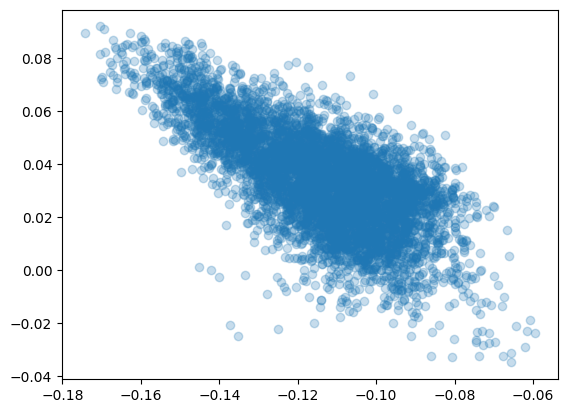

Epoch 1, training loss: 0.41, val utility: -0.03, confusion: 0.9196597933769226


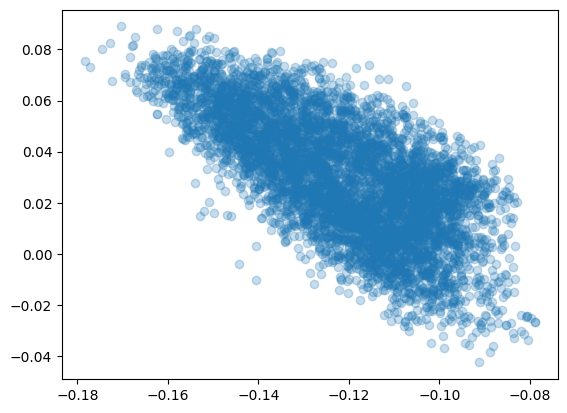

Epoch 2, training loss: 0.32, val utility: -0.17, confusion: 0.8686751127243042


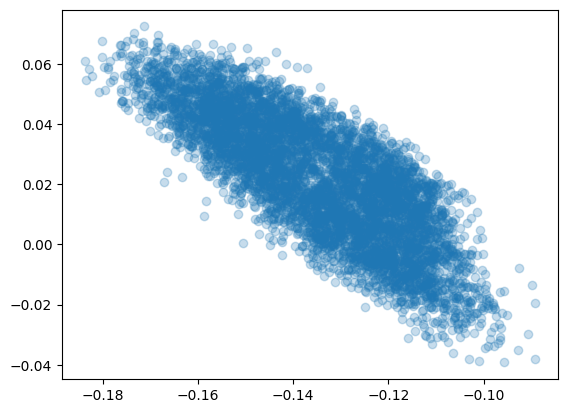

Epoch 3, training loss: 0.25, val utility: -0.32, confusion: 0.8056154251098633


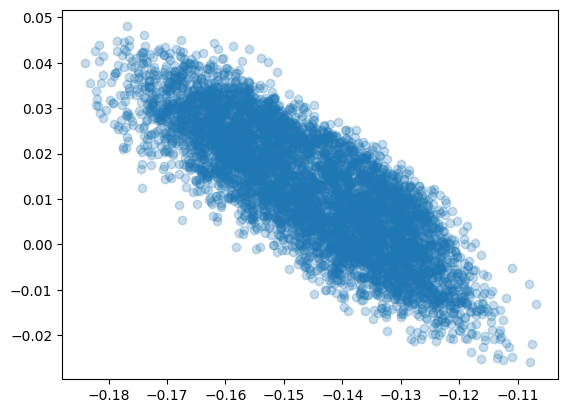

Epoch 4, training loss: 0.18, val utility: -0.12, confusion: 0.7432190179824829


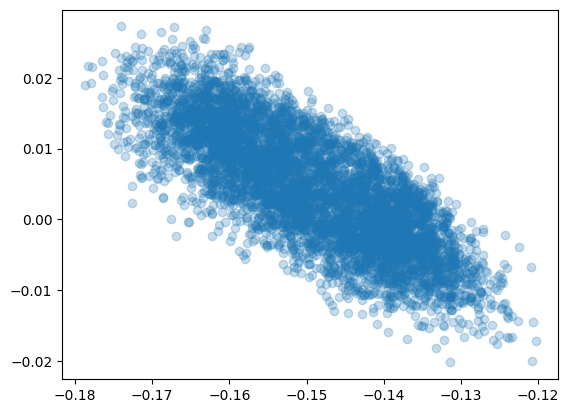

Epoch 5, training loss: 0.11, val utility: -0.11, confusion: 0.6910648345947266


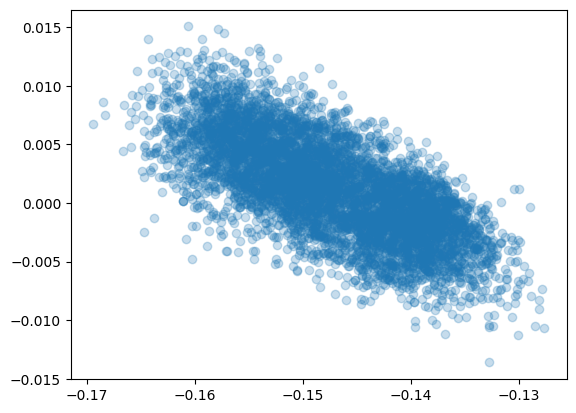

Epoch 6, training loss: nan, val utility: -0.04, confusion: 0.6495564579963684


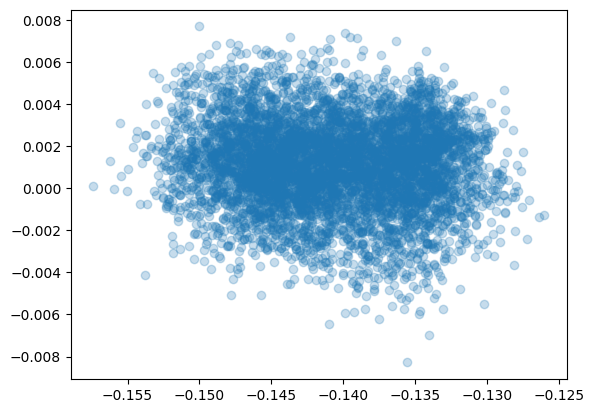

Epoch 7, training loss: nan, val utility: -0.39, confusion: 0.6260849237442017


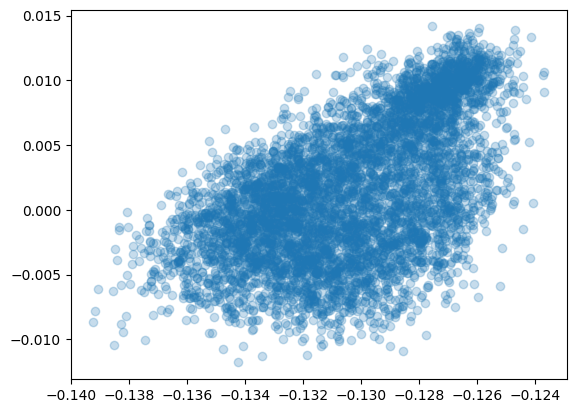

Epoch 8, training loss: nan, val utility: -0.74, confusion: 0.6262692213058472


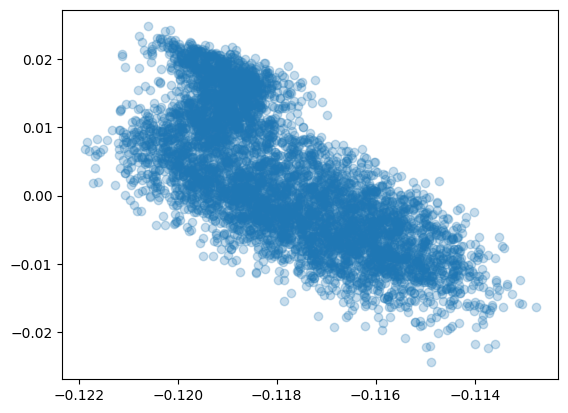

Epoch 9, training loss: nan, val utility: -1.00, confusion: 0.6382911205291748


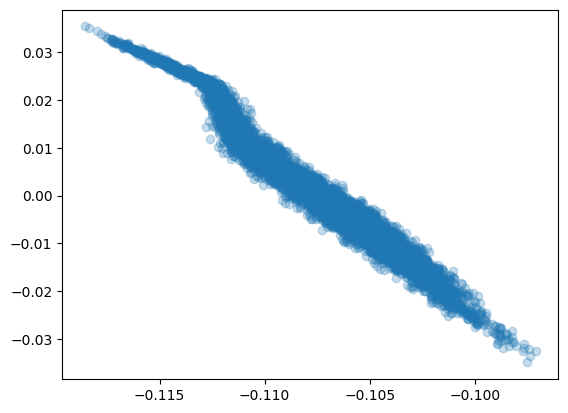

RuntimeError: Function 'AddmmBackward0' returned nan values in its 0th output.

In [19]:
from itertools import chain
#Training in action
os.makedirs('../model_weights', exist_ok=True)
device=DEVICE
net=rlPolicy(128, device)
optim1 = optim.Adam(chain(policy_agent.parameters(), tam_gru.parameters()), lr=0.0001, weight_decay=0.01)
optim3 = optim.Adam(decoder.parameters(), lr=0.0001, weight_decay=0.01)
loss=train(train_iter, val_iter, optim1, optim3, device, 50, 'DLRL')

In [ ]:
avgReturn=test(net, test_iter, device, 25, 'DLRL')
print(f'On average, every 24 days the algorithm yields:{avgReturn}' )
demo_iter=DataIterGen(0, stockList1, demo=True)
demo(net, demo_iter , device, 25, 'DLRL')

In [ ]:
train_iter, val_iter, test_iter=DataIterGen(3, stockList1)

In [ ]:
optim1 = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.01)
loss=train(net, train_iter, val_iter, optim1, device, 30, 'DLRL', lossfn=lossFunc2)

In [ ]:
avgReturn=test(net, test_iter, device, 4, 'DLRL')
print(f'On average, every 24 days the algorithm yields:{avgReturn}' )
demo_iter=DataIterGen(3, stockList1, demo=True)
demo(net, demo_iter , device, 4, 'DLRL')

In [ ]:
train_iter, val_iter, test_iter=DataIterGen(2, stockList1)

In [ ]:
loss=train(net, train_iter, val_iter, optim1, device, 30, 'DLRL', lossfn=lossFunc2)

In [ ]:
avgReturn=test(net, test_iter, device, 17, 'DLRL')
print(f'On average, every 24 days the algorithm yields:{avgReturn}' )

In [ ]:
demo_iter=DataIterGen(2, stockList1, demo=True)

In [ ]:
demo(net, demo_iter , device, 17, 'DLRL')

In [ ]:
#Training in action
train_iter, val_iter, test_iter=DataIterGen(5, stockList1)

In [ ]:
loss=train(net, train_iter, val_iter, optim1, device, 30, 'DLRL', lossfn=lossFunc2)

In [ ]:
avgReturn=test(net, test_iter, device, 12, 'DLRL')
print(f'On average, every 24 days the algorithm yields:{avgReturn}' )

In [ ]:
demo_iter=DataIterGen(5, stockList1, demo=True)
demo(net, demo_iter , device, 12, 'DLRL')